# 0. Предварительная настройка

Подключим сервисы Google:

In [ ]:
from google.colab import data_table

from google.colab import drive
drive.mount('/content/drive')

print("Setup Complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup Complete


Подключим необходимые модули:

In [ ]:
import os
import chardet
import gc
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

print("Setup Complete")

Setup Complete


Определим используемые функции:

In [ ]:
# функция для определения используемой в файле кодировки и языка
def get_file_charset(file_path, fraction = 8, print_result = False):
  """
  Checks the encoding used in the file

  Parameters
  ----------

  file_path : {Path}
    Full path to the file

  fraction : {int}
    The size of the fraction of the total file size that will be used to determine the encoding.
    For example, if the fraction size is 1/8, then fraction = 8.

  print_result : {bool}
    If True - print result to console, else - return dict with results 

  Returns
  -------
   : [dict]
    Return dict with resuts, like
    {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

  """
  with open(file_path, 'rb') as rawdata:
    file_size = os.path.getsize(file_path)
    chunk_size = file_size // fraction
    result = chardet.detect(rawdata.read(chunk_size))

    if print_result:
      print('File full path:', file_path)
      print('File size (bytes):', file_size)
      print('The specified fraction size is 1/', fraction, '. This is ', chunk_size, ' bytes.', sep="")
      print('Detected charset: ', result['encoding'], ', suggested file language: ', result['language'], sep="")
      return None

    return(result)


# Функция для проверки категориальных данных датафрейма.
def show_unique_values(df, col_names):
  
  result = pd.DataFrame(index=col_names, columns = ['unique_values','unique_values_count'])

  for cur_col_name in col_names:
    result.loc[cur_col_name,['unique_values']] = str(sorted(df[cur_col_name].unique()))
    result.loc[cur_col_name,['unique_values_count']] = df[cur_col_name].nunique()

  return(result)


# Функция для проверки диапазона числовых значений датафрейма
def check_columns_boundaries(df, columns_names):
  """ """
  for name in columns_names:
    min = df[name].dropna().min()
    max = df[name].dropna().max()
    print("Column", name, "has values in the range:", min, " - ", max)

# Функция формирующая отчет по отсутсвующим значениям
def miss_val_summ_report(df):

  # Найдём общие показатели 
  # Кол-во и процент NULL
  df_total_cells = np.product(df.shape)
  df_total_is_null = df.isnull().sum().sum()
  df_total_is_null_proc = df_total_is_null * 100 / df_total_cells

  # Кол-во и процент NaN
  df_total_na = df.isna().sum().sum()
  df_total_is_na_proc = df_total_na * 100 / df_total_cells

  missing_values = pd.DataFrame(columns = ['Null_COUNT', 'Null_%', 'NaN_COUNT', 'NaN_%'])

  missing_values['Null_COUNT'] = heart_raw_data.isnull().sum()
  missing_values['Null_%'] = missing_values['Null_COUNT'] * 100 / heart_raw_data.shape[0]
  missing_values['NaN_COUNT'] = heart_raw_data.isna().sum()
  missing_values['NaN_%'] = missing_values['NaN_COUNT'] * 100 / heart_raw_data.shape[0]

  print('Dataframe missing values summary:')
  print(missing_values)
  print('The total number of cells with NULL is ', df_total_is_null, ' which is ', df_total_is_na_proc, '% of the total number of cells.', sep="")
  print('The total number of cells with NaN is ', df_total_na, ' which is ', df_total_is_na_proc, '% of the total number of cells.', sep="")
  
  return None


print("Setup Complete")

Setup Complete


# Problem Definition (Описание проблемы)

Необходимо проанализировать датасет по сердечным приступам и разработать модель классификации, способную разделить (елассифицировать) пациентов на две группы по вероятности возникновения сердечного приступа.

# Data Extraction (Извлечение данных)

Определим несколько вспомогательных переменных указывающих полный путь к файлам данных:

In [ ]:
# Переменные для Python
heart_filepath = Path("/content/heart.csv")

# Переменные для Linux
os.environ['os_heart_filepath'] = "/content/heart.csv"

print("SUCCESS")

SUCCESS


Разархивируем датасет:

In [ ]:
dataset_filepath = "/content/drive/MyDrive/MIPT/Data_Scientist/Data_analysis_techniques_and_machine_learning_methods/Part_1/Homework_1/dataset.zip"
destination_filepath = "/content/"

!unzip $dataset_filepath -d $destination_filepath
!ls -la

Archive:  /content/drive/MyDrive/MIPT/Data_Scientist/Data_analysis_techniques_and_machine_learning_methods/Part_1/Homework_1/dataset.zip
replace /content/heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/heart.csv      
replace /content/o2Saturation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/o2Saturation.csv  
total 56
drwxr-xr-x 1 root root  4096 Sep 28 12:59 .
drwxr-xr-x 1 root root  4096 Sep 28 07:21 ..
drwxr-xr-x 4 root root  4096 Sep 26 13:44 .config
drwx------ 5 root root  4096 Sep 28 07:22 drive
-rw-r--r-- 1 root root 11323 Mar 22  2021 heart.csv
-rw-r--r-- 1 root root 21440 Mar 22  2021 o2Saturation.csv
drwxr-xr-x 1 root root  4096 Sep 26 13:45 sample_data


## Проверим визуально соответсвие файлов датасета формату CSV

Посмотрим первые несколько строк наших файлов данных. Это даст нам возможность сэкономить время и решить большую часть проблем этапа загрузки данных заблаговременно.

Выведем первые 10 строк файла `heart.csv`:

In [ ]:
!head -10 $os_heart_filepath

age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1


Как видно из вывода выше файлы соответсвуют формату CSV, кроме того:
- в файле присутсвует заголовок
- разделителем столбцов явлсяется символ `,`
- в качестве десятичного разделителя используется символ `.`

## Проверим используемую в файлах датасета кодировку

Определим испольуемую в файлах кодировку и язык:

In [ ]:
get_file_charset(heart_filepath, fraction = 4, print_result=True)

File full path: /content/heart.csv
File size (bytes): 11323
The specified fraction size is 1/4. This is 2830 bytes.
Detected charset: ascii, suggested file language: 


Предполагаемая кодировка символов используемая в файле - ascii. Используемый язык не удается определить, потому что файл состоит в основоном из числовых данных. Так как у кодировки UTF8 есть совместимость с ASCII, то в процессе загрузки данных будем использовать UTF8. 

## Загрузка данных в Pandas

В процессе загрузки данных в датафрейм будем дополнительно зададим параметр `;low_memory`, что позволит Pandas автоматически определять используемый в столбцах тип данных основываясь на всем файле.

Загрузим данные в Pandas и просмотрим первые 10 строк датафрема:

In [ ]:
heart_raw_data = pd.read_csv(heart_filepath, encoding='UTF8', sep=',', decimal='.', low_memory=True)

heart_raw_data.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Посмотрим на размеры датафрейма:

In [ ]:
heart_raw_data.shape

(303, 14)

# Data cleaning (Отчистка данных)

## Exploring the data structure (Изучение структуры данных датасета)

В большинстве случаев удается получить доступ к дополнительной информации о структуре данных датасета. Знание структуры и характера хранящихся в файлах данных информации позволяет заметить проблемные моменты на более ранних этапах анализа данных, что в свою очередь позволяет решить их заранее.

В нашем датасете содержатся следующие данные:    

Файл `heart.csv`:
- `age` : Возраст пациента
- `sex` : пол пациента
  - `0` : женщина
  - `1` : мужчина
-  `cp` : Тип боли в грудной клетке
  - `0` : типичная ангина
  - `1` : атипичная ангина
  - `2` : неангинальная боль
  - `3` : бессимптомная
- `trtbps` :  артериальное давление в состоянии покоя (в мм рт. ст.)
- `chol` : уровень холестерина в мг/дл, полученный через датчик ИМТ
- `fbs` : (сахар в крови натощак > 120 мг/дл) 
  - `1` : Истина
  - `0` : Ложь
- `rest_ecg` : результаты электрокардиографии в состоянии покоя.
  - `0`: норма
  - `1`: наличие аномалии ST-T волны (инверсии T волны и/или повышение или понижение ST > 0,05 мВ)
  - `2`: наличие вероятной или определенной гипертрофии левого желудочка по критериям Эстеса
- `thalach` :  максимальная достигнутая частота сердечных сокращений
- `exang`: стенокардия, вызванная физической нагрузкой
  - `1` : да
  - `0` : нет
- `oldpeak` : депрессия сегмента ST, вызванная физической нагрузкой по сравнению с состоянием покоя
- `slope` : наклон сегмента ST пика физической нагрузки 
  - `0` : нисходящий)
  - `1` : плоский
  - `2` : восходящий; 
- `caa`: количество крупных сосудов (0-3)
- `thall` :  талассемия
  - `0` : ноль
  - `1` : фиксированный дефект
  - `2` : норма
  - `3` : обратимый дефект
- `output`: диагноз заболевания сердца (ангиографический статус заболевания)
	- `0`: < 50% сужение диаметра, меньше вероятность заболевания сердца
	- `1`: > 50% сужение диаметра, больше шансов на заболевание сердца

Файл `o2Saturation.csv`:
В этом файле всего один столбец без заголовка. Это данные по насыщению крови кислородом (сатурации). Мы не будем их использовать.

Еще раз посмотрим на наименование полей в датаврейме:

In [ ]:
heart_raw_data.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

Судя по выводу, некоторые поля датафрейма имеют некорректные имена, исправим это:

In [ ]:
heart_raw_data.rename(columns = {'restecg':'rest_ecg', 'thalachh':'thalach', 'exng':'exang', 'slp':'slope'}, inplace = True)

heart_raw_data.head()

,age,sex,cp,trtbps,chol,fbs,rest_ecg,thalach,exang,oldpeak,slope,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Checking data types (Проверка типов данных)


Обычно при загрузке данных в датафрейм, Pandas задает типы данных используемые в столбцах автоматически, но это не всегда рационально и правильно. Кроме того, использование корректных типов данных является основой правильной работы любых функций и методов обработки данных.

Проверим заданные автоматически типы данных столбцов.

### Категориальные данные

Исходя из описания датасета ясно, что столбцы `sex`, `cp`, `fbs`, `rest_ecg`, `exang`, `slope`, `thall`, `output` содержат категориальные данные. Посмотрим какой тип данных используется в датафрейме для этих столбцов:

In [ ]:
# Общий список всех категориальных столбцов
cat_columns = ['sex', 'cp', 'fbs', 'rest_ecg', 'exang', 'slope', 'thall', 'output']

heart_raw_data[cat_columns].dtypes

sex         int64
cp          int64
fbs         int64
rest_ecg    int64
exang       int64
slope       int64
thall       int64
output      int64
dtype: object

Тип данных задан не коректно. Это не целочисленные данных. Перед изменением типа категориальных столбцов необходимо проверить их на несогласованный ввод.

#### Проверка на несогласованный ввод

Проверим столбцы на несогласованный ввод:

In [ ]:
show_unique_values(heart_raw_data, cat_columns)

,unique_values,unique_values_count
sex,"[0, 1]",2
cp,"[0, 1, 2, 3]",4
fbs,"[0, 1]",2
rest_ecg,"[0, 1, 2]",3
exang,"[0, 1]",2
slope,"[0, 1, 2]",3
thall,"[0, 1, 2, 3]",4
output,"[0, 1]",2


Судя по выводу, кол-во категорий небольшое и среди них нет проблемных (количество найденных для каждого параметра уникальных значений совпадает с общим количеством уникальных значений и описанием датасета). Нет похожих уникальных значений.

#### Приведение к корректному типу данных

Приведем категориальные столбцы к соответствующему типу:

In [ ]:
heart_raw_data[cat_columns] = heart_raw_data[cat_columns].astype('category')

heart_raw_data[cat_columns].dtypes

sex         category
cp          category
fbs         category
rest_ecg    category
exang       category
slope       category
thall       category
output      category
dtype: object

### Числовые данные

В нашем датафрейме еще остались столбцы с числовым типом данных (целочисленный и действительный типы). Получим список этих столбцов:

In [ ]:
float_columns = list(heart_raw_data.select_dtypes(include=[float]).columns)
int_columns = list(heart_raw_data.select_dtypes(include=[int]).columns)

print('Columns with float dtype: ', float_columns)
print('Columns with integer dtype: ', int_columns)

# Общий список имен всех числовых столбцов
numeric_columns = int_columns + float_columns 
print('Columns with numeric dtype: ',numeric_columns)

Columns with float dtype:  ['oldpeak']
Columns with integer dtype:  ['age', 'trtbps', 'chol', 'thalach', 'caa']
Columns with numeric dtype:  ['age', 'trtbps', 'chol', 'thalach', 'caa', 'oldpeak']


##### Проверка на несогласованный ввод

Проверить числовых данные на несогласованный ввод можно путем проверки допустимого диапазона значений. Для этого необходимо:
1. Найти экстремумы (минимальное и максимальное значения) параметра (в столбце).
2. Аналитически проверить допустимость полученных на шаге 1 экстремумов.

Например, возможные температур на Земле укладываются в диапазон от +45.4 до −67.8 градусов Цельсия. Будет странно, если мы обнаружим среднемесячную температуру -273 градуса.

Проверим столбцы с числовым типом данных:

In [ ]:
check_columns_boundaries(heart_raw_data, numeric_columns)

Column age has values in the range: 29  -  77
Column trtbps has values in the range: 94  -  200
Column chol has values in the range: 126  -  564
Column thalach has values in the range: 71  -  202
Column caa has values in the range: 0  -  4
Column oldpeak has values in the range: 0.0  -  6.2


Все в допустимых приделах.

##### Приведение к корректному типу данных

Приведем параметр `oldpeak` к типу `np.float16`. Целочисленные параметры age', 'trtbps', 'chol', 'thalach', 'caa' приведем к типу `int16`:

In [ ]:
heart_raw_data[float_columns] = heart_raw_data[float_columns].astype(np.float16, errors='raise')

heart_raw_data[int_columns] = heart_raw_data[int_columns].astype(np.int16, errors='raise')

heart_raw_data.dtypes

age            int16
sex         category
cp          category
trtbps         int16
chol           int16
fbs         category
rest_ecg    category
thalach        int16
exang       category
oldpeak      float16
slope       category
caa            int16
thall       category
output      category
dtype: object

## Дополнительные манипуляции с данными без их изменения

Кроме всего вышеизложенного, для удобства восприятия информации переставим столбцы в датафрейме в порядке "целочисленные - действительные - категориальные":

In [ ]:
new_order = int_columns + float_columns + cat_columns

heart_raw_data = heart_raw_data[new_order]

heart_raw_data.dtypes

age            int16
trtbps         int16
chol           int16
thalach        int16
caa            int16
oldpeak      float16
sex         category
cp          category
fbs         category
rest_ecg    category
exang       category
slope       category
thall       category
output      category
dtype: object

На данном этапе целесообразно содать копию данных без их непосредственного изменения. Сделаем это:

In [ ]:
heart_data = heart_raw_data.copy()

heart_data.head()

,age,trtbps,chol,thalach,caa,oldpeak,sex,cp,fbs,rest_ecg,exang,slope,thall,output
0,63,145,233,150,0,2.300781,1,3,1,0,0,0,1,1
1,37,130,250,187,0,3.500000,1,2,0,1,0,0,2,1
2,41,130,204,172,0,1.400391,0,1,0,0,0,2,2,1
3,56,120,236,178,0,0.799805,1,1,0,1,0,2,2,1
4,57,120,354,163,0,0.600098,0,0,0,1,1,2,2,1


## Handling Missing Values (Обработка отсуствующих значений). 

Отсутсвующие значения в данных могут стать источником большого колличества проблем начиная с неверной интерпритации, вплоть до некоректной работы модели.

Проверим, есть ли в датасете отсуствующие значения:

In [ ]:
miss_val_summ_report(heart_raw_data)

Dataframe missing values summary:
          Null_COUNT  Null_%  NaN_COUNT  NaN_%
age                0     0.0          0    0.0
trtbps             0     0.0          0    0.0
chol               0     0.0          0    0.0
thalach            0     0.0          0    0.0
caa                0     0.0          0    0.0
oldpeak            0     0.0          0    0.0
sex                0     0.0          0    0.0
cp                 0     0.0          0    0.0
fbs                0     0.0          0    0.0
rest_ecg           0     0.0          0    0.0
exang              0     0.0          0    0.0
slope              0     0.0          0    0.0
thall              0     0.0          0    0.0
output             0     0.0          0    0.0
The total number of cells with NULL is 0 which is 0.0% of the total number of cells.
The total number of cells with NaN is 0 which is 0.0% of the total number of cells.


Отсутсвующих значений нет.

## Data deduplication (Дедубликация данных)

Начилие дубликатов в данных может стать серьезной проблемой, особенно если дубликатов много. Проверим наши данные на наличие дубликатов строк. Для начала посчитаем сколько их:

In [ ]:
(heart_data.duplicated(keep=False)).sum()

2

У нас есть всего 2 повторяющиеся строки. Посмотрим на них:

In [ ]:
heart_data[heart_data.duplicated(keep=False) == True]

,age,trtbps,chol,thalach,caa,oldpeak,sex,cp,fbs,rest_ecg,exang,slope,thall,output
163,38,138,175,173,4,0.0,1,2,0,1,0,2,2,1
164,38,138,175,173,4,0.0,1,2,0,1,0,2,2,1


Такое количество дублей можно просто отбросить. Это не приведет к проблемам.

In [ ]:
heart_data = heart_data.drop_duplicates()

heart_data.shape

(302, 14)

# Primary data analysis (Первичный анализ данных)

## Матрица диаграмм рассеяния (числовые параметры)

Матрица диаграмм рассеяния отвечает на следующие вопросы:
- Существуют ли парные связи между различными переменными? И если есть взаимосвязи, то каков характер этих взаимосвязей?
- Есть ли в наборе данных какие-либо выбросы?
- Имеется ли в наборе данных кластеризация по группам на основе определенной переменной?

Визуализируем наши данные с помощью матрицы диаграмм рассеивания:

<Figure size 864x432 with 0 Axes>

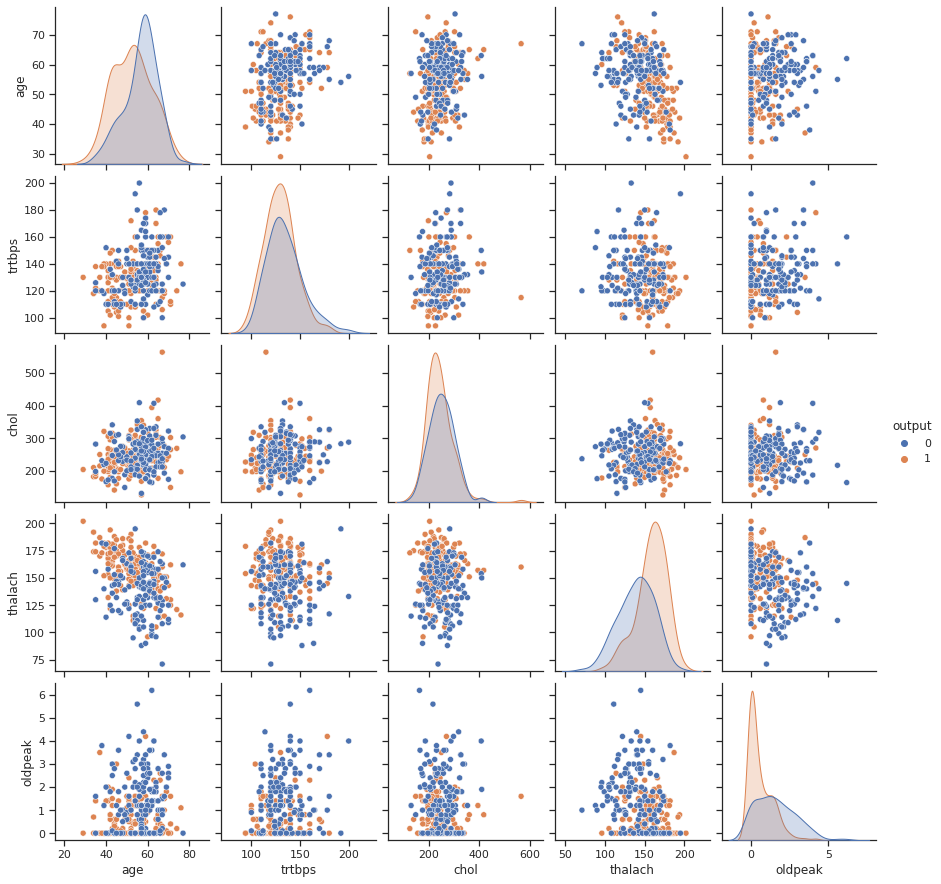

In [ ]:
import seaborn as sns


sns.set_theme(style="ticks")
plt.figure(figsize=(12,6))

sns.pairplot(heart_data,
             x_vars=['age', 'trtbps', 'chol', 'thalach', 'oldpeak'],
             y_vars=['age', 'trtbps', 'chol', 'thalach', 'oldpeak'], 
             height=2.5, 
             hue="output")

Из графиков видно:    
1) Чёткой кластеризации по группам на графиках рассеивания нет.     
2) Судя по графикам плотности, практически во всех параметрах данные хорошо сбалансированны (кривые плотности пациентов с высокой вероятностью осложнений сердца перекрываются по большей площади с кривыми плотности пациентов без высокой вероятности осложнений).

Посмтрим отдельно на такие параметры как возраст (age), уровень холестерина (chol) и максимальная достигнутая частота сердечных сокращений (thalach):

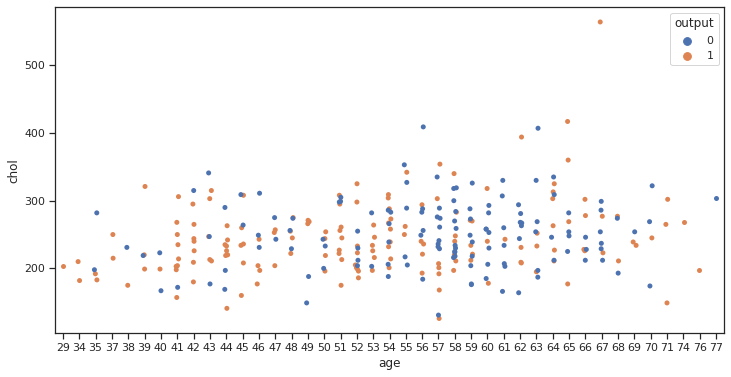

In [ ]:
plt.figure(figsize=(12,6))
sns.stripplot(data=heart_data, x="age", y="chol", hue="output")

Высокий холестерин в молодом и зрелом возрасте может указывать на возникновение проблем с сердцем.

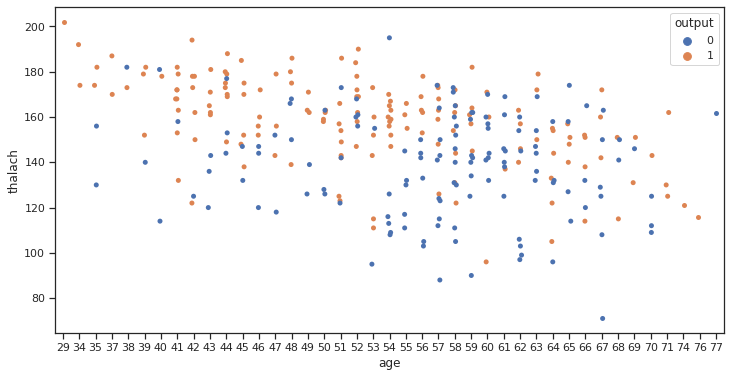

In [ ]:
plt.figure(figsize=(12,6))
sns.stripplot(data=heart_data, x="age", y="thalach", hue="output")

Чем выше пульс в молодом и среднем возрасте, тем выше вероятность проблем с сердцем.

## Роевая диаграмма (категориальные параметры)

Роевая диаграмма хорошо подходит для визального анализа категориальных данных.

### Количество крупных сосудов

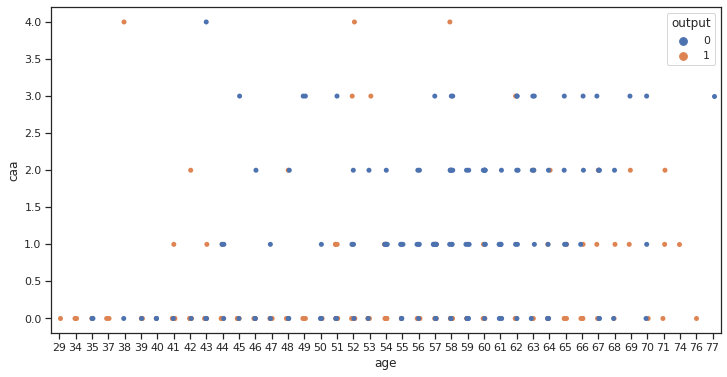

In [ ]:
plt.figure(figsize=(12,6))
sns.stripplot(data=heart_data, x="age", y="caa", hue="output")

Количество крупных сосудов практически никак не влияет не возникновение проблем с сердцем.

### Пол

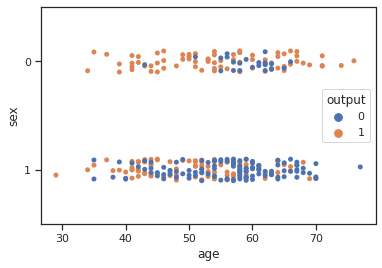

In [ ]:
sns.stripplot(data=heart_data, x="age", y="sex", hue="output")

В данном датасете, среди женьщин проблемы с сердцем встречаются чаще.

### Cахар в крови натощак

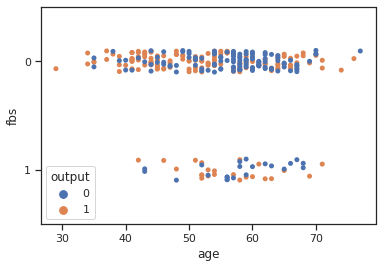

In [ ]:
sns.stripplot(data=heart_data, x="age", y="fbs", hue="output")

Среди пациентов с повышенным сахаром вероятность проблем с серцем выше.

### Результаты электрокардиографии в состоянии покоя

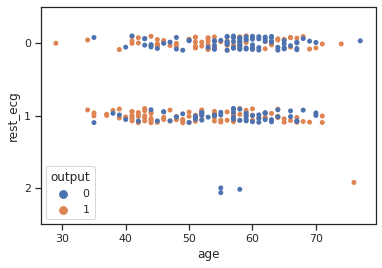

In [ ]:
sns.stripplot(data=heart_data, x="age", y="rest_ecg", hue="output")

Результаты электрокардиографии в состоянии покоя не репрезентативны. Кол-во людей с нормальной электрокардиограммой и аномалиями ST-T волны существенно превышают количество людей с гипертрофией.

### Стенокардия при физической нагрузке

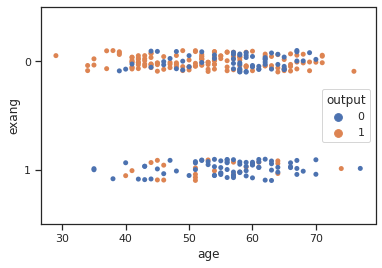

In [ ]:
sns.stripplot(data=heart_data, x="age", y="exang", hue="output")

Стенокардия при физической нагрузке является хорошим признаком наличия проблем с сердцем. Среди пациетов со стенокардией проблемы с сердцем встречаются гораздо чаще.

### Наклон ST сегмента  пика физической нагрузки

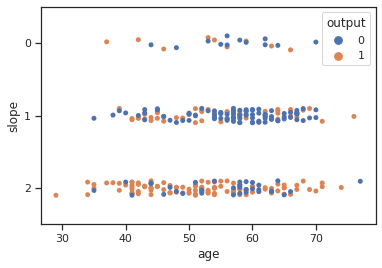

In [ ]:
sns.stripplot(data=heart_data, x="age", y="slope", hue="output")

Среди пациентов с восходящим и плоским наклоном сегмента ST проблемы с сердцем встречаются чаще. Но выборка пациентов с нисходящим сегментом очень мала. Данные по этому параметру не репрезентативны. 

### Талассемия

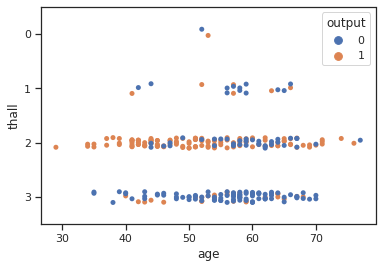

In [ ]:
sns.stripplot(data=heart_data, x="age", y="thall", hue="output")

Среди пациентов с таласимией проблемы с сердцем встречаются гораздо чаще. Но, опять же выборка пациентов с ее отсутствием нерепрезентативна.

# Baseline (базовая модель)

В качетсве базовой модели (baseline) возьмём модель линейной регрессии с гиперпараметрами по умолчанию.

## Selecting a metric to validate the classification model (Выбор метрики для валидации модели классификации)

Выберем для валидации метрику f1_score. Дополнительно будем оценивать модель с помощью отчета классификации из модуля sklearn

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from sklearn.metrics import classification_report

## Categorical features (категориальные параметры) 

Все категориальные параметры в нашем датасете уже закодированны с помощью порядкового кодирования. Оставим без изменения.

## Selecting data for modeling (Выбор данных для моделирования)

### Selecting a prediction target (Выбор цели прогноза)

В качестве цели прогноза у нас выступает столбец `output` (диагноз заболевания сердца) содержащий два типа значений:
- `0`: < 50% сужение диаметра, меньше вероятность заболевания сердца
- `1`: > 50% сужение диаметра, больше шансов на заболевание сердца

In [ ]:
y = heart_data['output']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: output, dtype: category
Categories (2, int64): [0, 1]

### Select model features (Выбор параметров модели)

In [ ]:
X = heart_data.drop('output', axis=1)
X

,age,trtbps,chol,thalach,caa,oldpeak,sex,cp,fbs,rest_ecg,exang,slope,thall
0,63,145,233,150,0,2.300781,1,3,1,0,0,0,1
1,37,130,250,187,0,3.500000,1,2,0,1,0,0,2
2,41,130,204,172,0,1.400391,0,1,0,0,0,2,2
3,56,120,236,178,0,0.799805,1,1,0,1,0,2,2
4,57,120,354,163,0,0.600098,0,0,0,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0,0.199951,0,0,0,1,1,1,3
299,45,110,264,132,0,1.200195,1,3,0,1,0,1,3
300,68,144,193,141,2,3.400391,1,0,1,1,0,1,3
301,57,130,131,115,1,1.200195,1,0,0,1,1,1,3


## Dividing the dataset into training and test samples (Разделение датасета на тренировочную и тестовую выборки)

Для проведения валидации модели необходимо, чтобы модель не тренировалась на данных используемых для ее оценки. Разделим данные на тренировочную и тестовую выборки в соотношении 70% тренировачных даных, 30% тестовых данных: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

X_train.head()

,age,trtbps,chol,thalach,caa,oldpeak,sex,cp,fbs,rest_ecg,exang,slope,thall
230,47,108,243,152,0,0.0,1,2,0,1,0,2,2
8,52,172,199,162,0,0.5,1,2,1,1,0,2,3
49,53,138,234,160,0,0.0,0,0,0,0,0,2,2
119,46,138,243,152,0,0.0,0,0,0,0,1,1,2
99,53,130,246,173,3,0.0,1,2,1,0,0,2,2


Используем при разделении датасета:
- встроенной поддержкой стратификации с помощью `stratify=y`. Cтратификация означает, что метод train_test_split возвращает обучающее и тестовое подмножества, которые имеют те же пропорции меток классов, что и входной набор данных.
- фиксированное случайное начальное значение генератора случайных числе `random_state=1`. Чтобы гарантировать воспроизводимость наших результатов.

## Scaling numerical parameters (Масштабирование числовых параметров)

Судя по величине стандартного отклонения `std` большинство параметров нашего набора данных изменяется в очень большом диапазоне и/или отличаться друг от друга на несколько порядков.

Для обеспечения оптимальной эффективности алгоритмов машинного обучения необходимо произвести масштабирование параметров. Масштабирование параметров выполняется для вещественных и целочисленных (не категориальных) параметров. Это критически важный шаг в конвейере предварительной обработки данных, так как позволяет снизить вычислительную емкость модели машинного обучения и повысить ее эффективность. 

Два наиболее часто используемых метода масштабирования - нормализация и стандартизация.

Нормализация - изменение масштаба признака на диапазон от О до 1, которое
представляет собой частный случай масштабирования по минимаксу (min-max scaling)

Cтандартизация - изменение набора даныых которое придает нашим данным характеристики стандартного нормального распределения: нулевое среднее и единичную дисперсию.  Стандартизация сохраняет полезную инормацию о выбросах и делает алгоритм менее чувствительным к ним. Стандартизация более практична для многих алгоритмов MO, особенно для алгоритмов наподобие градиетного спуска.

Так как мы планируем использовать разные модели машинного обучения (в том числе с rрадиентным спуском), произведем стандартизацию нашего набора данных:

In [ ]:
X[int_columns + float_columns].head()

,age,trtbps,chol,thalach,caa,oldpeak
0,63,145,233,150,0,2.300781
1,37,130,250,187,0,3.500000
2,41,130,204,172,0,1.400391
3,56,120,236,178,0,0.799805
4,57,120,354,163,0,0.600098


In [ ]:
# Создадим копию тренировочных и тестовых наборов
X_train_std = X_train
X_test_std = X_test

cur_scaler = StandardScaler()

# Стандартизируем тренировачный набор данных
X_train_std[numeric_columns] = cur_scaler.fit_transform(X_train[numeric_columns])

# Пирименим стандартизацию с теми же параметрами на тестовы набор.
X_test_std[numeric_columns] = cur_scaler.transform(X_test[numeric_columns])

# Получим имена столбцов
X_train_column_names = X_train.columns
X_test_column_names = X_test.columns

# Вернём имена столбцов нормализованным данным
X_train_std = pd.DataFrame(X_train_std, columns=X_train_column_names)
X_test_std = pd.DataFrame(X_test_std, columns=X_test_column_names)

# Проверим как прошла стандартизация тренировочного и тестового наборов
X_train_std.head()

,age,trtbps,chol,thalach,caa,oldpeak,sex,cp,fbs,rest_ecg,exang,slope,thall
230,-0.851825,-1.363946,-0.025449,0.089838,-0.742479,-0.882048,1,2,0,1,0,2,2
8,-0.293295,2.256798,-0.894081,0.523610,-0.742479,-0.458677,1,2,1,1,0,2,3
49,-0.181589,0.333278,-0.203124,0.436855,-0.742479,-0.882048,0,0,0,0,0,2,2
119,-0.963531,0.333278,-0.025449,0.089838,-0.742479,-0.882048,0,0,0,0,1,1,2
99,-0.181589,-0.119315,0.033776,1.000758,2.158689,-0.882048,1,2,1,0,0,2,2


In [ ]:
X_test_std.head()

,age,trtbps,chol,thalach,caa,oldpeak,sex,cp,fbs,rest_ecg,exang,slope,thall
168,0.935472,-0.119315,0.191709,-0.127048,0.224577,0.303723,1,0,0,0,0,1,3
116,-1.522062,-0.119315,-0.597956,0.783873,-0.742479,0.811439,1,2,0,0,0,1,2
259,-1.857180,-0.685056,-0.262349,1.391153,-0.742479,2.336238,1,3,0,1,1,1,3
174,0.600354,-0.119315,-0.755890,-0.777705,1.191633,1.150467,1,0,0,0,1,1,3
190,-0.405001,-0.119315,1.198533,-0.343934,-0.742479,0.134209,0,0,0,1,1,1,3


## Optimization of hyperparameters (Оптимизация гиперпараметров)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_grid = {'C': [ 0.01, 0.1, 1, 10, 100],
                'penalty': ['l2'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

log_reg = LogisticRegression()

gs = GridSearchCV(log_reg, log_reg_grid, cv=5, n_jobs=-1, scoring='f1', verbose=1)
gs.fit(X_train_std, y_train)

# Сохраним оптимальные параметры базовой модели для дальнейшего использования
baseline_model_best_param = gs.best_params_

val_model = LogisticRegression(**gs.best_params_)
val_model.fit(X_train_std, y_train)
prediction = val_model.predict(X_test_std)
  
score = f1_score(y_test, prediction)
print('Best GridSearch F1_score:', gs.best_score_, 'with params:', gs.best_params_)
print('F1 on test:', score, '\n')

print(classification_report(y_test, prediction))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best GridSearch F1_score: 0.8365483190466069 with params: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
F1 on test: 0.8932038834951458 

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        42
           1       0.85      0.94      0.89        49

    accuracy                           0.88        91
   macro avg       0.89      0.87      0.88        91
weighted avg       0.88      0.88      0.88        91




## Results (Результаты)

В качестве базовой была выбранна модель логистической регрессии (LogisticRegression) для которой удалось достичь F1 = 0.8932038834951458 на тестовой выборке. 

# Feature Engineering (Инженерия параметров)

## Function for comparing different approaches (Функция для сравнения различных подходов)

Определим небольшую функцию для сравнения различных подходов к работе с категориальными переменными.

In [ ]:
# Функция для сравнения различных подходов на этапе инженерии параметров
def score_dataset(X_train, y_train, X_test, y_test):
    model = LogisticRegression(C = 0.1, solver = 'newton-cg', penalty = 'l2')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(classification_report(y_test, preds))
    
    return f1_score(y_test, preds)

## One-Hot Encoding for сategorical features (Кодирование с помощью метода "горячей единицы" для категориальных параметров)

Мы используем класс `OneHotEncoder` из scikit-learn, чтобы получить кодированные с помощью метода "горячей единицы" категориальные столбцы. Есть ряд параметров, с помощью которых можно настроить его поведение:

- Мы устанавливаем `handle_unknown = 'ignore'`, чтобы избежать ошибок, когда данные проверки содержат классы, которые не представлены в данных обучения, и

- установка `sparse = False` гарантирует, что закодированные столбцы возвращаются в виде массива numpy (вместо разреженной матрицы).

Чтобы использовать кодировщик, мы предоставляем ему только категориальные столбцы, которые мы хотим закодировать с помощью метода "горячей единицы". Например, для кодирования обучающих данных мы предоставляем `X_train_std [cat_columns]`. (`cat_columns` в ячейке кода ниже представляет собой список имен столбцов с категориальными данными, поэтому `X_train_std[cat_columns]` содержит все категориальные данные в обучающем наборе.)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Общий список всех категориальных столбцов без цели предсказания
features_cat_columns = ['sex', 'cp', 'fbs', 'rest_ecg', 'exang', 'slope', 'thall']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_std[features_cat_columns]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test_std[features_cat_columns]))

# One-hot encoding удаляет индексы строк вернём их
OH_cols_train.index = X_train_std.index
OH_cols_test.index = X_test_std.index

# Удалим столбцы с категориальными данными (мы заменим их на столбцы 
# закодированные с помощью метода "горячей единицы")
num_X_train = X_train_std.drop(features_cat_columns, axis=1)
num_X_test = X_test_std.drop(features_cat_columns, axis=1)

# Добавим столбцы закодированные с помощью метода "горячей единицы" 
# к числовым параметрам
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Измерим метрики для подхода с кодированием категориальных переменных с помощью
# OneHotEncoder

print(score_dataset(OH_X_train, y_train, OH_X_test, y_test))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        42
           1       0.88      0.92      0.90        49

    accuracy                           0.89        91
   macro avg       0.89      0.89      0.89        91
weighted avg       0.89      0.89      0.89        91

0.9


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


С помшью OneHotEncoder удалось улучшить F1_score = 0.9. Дальше будем использовать данные подготовленные с OneHotEncoder

# Test other models (Проверка других моделей)

## Метод k-ближайщих соседей

Подберем наилучщие параметры и вычислим метрику на тестовой выборке:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Зададим сетку - среди каких значений выбирать наилучший параметр.
# knn_grid = {'n_neighbors': np.array(np.linspace(15, 30, 15), dtype='int'),
#             'algorithm': ['ball_tree', 'kd_tree', 'brute']}

knn_grid = {'n_neighbors': [i for i in range(1, 52) if i % 2 == 0],
            'algorithm': ['ball_tree', 'kd_tree', 'brute']}


# Будем использовать модель k ближайших соседей
knn = KNeighborsClassifier()

gs = GridSearchCV(knn, knn_grid, cv=5, n_jobs=-1, scoring='f1', verbose=2, error_score='raise')
gs.fit(OH_X_train, y_train)

val_model = KNeighborsClassifier(**gs.best_params_)
val_model.fit(OH_X_train, y_train)
prediction = val_model.predict(OH_X_test)
score = f1_score(y_test, prediction)

print(classification_report(y_test, prediction))
print('Best GridSearch F1_score:', gs.best_score_, 'with params:', gs.best_params_)
print('F1 on test:', score)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        42
           1       0.82      0.94      0.88        49

    accuracy                           0.86        91
   macro avg       0.87      0.85      0.85        91
weighted avg       0.86      0.86      0.86        91

Best GridSearch F1_score: 0.8411915613294696 with params: {'algorithm': 'ball_tree', 'n_neighbors': 50}
F1 on test: 0.8761904761904763


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


В случае с классификатором KNN удалось добиться F1 = 0.8761904761904763 при следующих гиперпараметрах: 
- алгоритм: 'ball_tree', 
- количество соседей: 50. 

## Модель случайного леса

Аналогично подберем наилучшие параметры для модели случайного леса:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Зададим сетку - среди каких значений выбирать наилучший параметр.
# rndf_grid = { 
#     'n_estimators': [i for i in range(1, 500) if i % 5 == 0],
#     'max_depth' : [i for i in range(1, 11)],
#     'criterion' : [ 'gini', 'entropy'],
#     'random_state': [12]}

rndf_grid = { 
    'n_estimators': [i for i in range(1, 100) if i % 5 == 0],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [i for i in range(1, 5)]}

rand_forest = RandomForestClassifier()

gs = GridSearchCV(rand_forest, rndf_grid, cv=5, n_jobs=-1, scoring='f1', verbose=2)
gs.fit(OH_X_train, y_train)

val_model = RandomForestClassifier(**gs.best_params_)
val_model.fit(OH_X_train, y_train)
prediction = val_model.predict(OH_X_test)
  
score = f1_score(y_test, prediction)

print(classification_report(y_test, prediction))
print('Best GridSearch F1_score:', gs.best_score_, 'with params:', gs.best_params_)
print('F1 on test:', score)

Fitting 5 folds for each of 152 candidates, totalling 760 fits
              precision    recall  f1-score   support

           0       0.94      0.74      0.83        42
           1       0.81      0.96      0.88        49

    accuracy                           0.86        91
   macro avg       0.87      0.85      0.85        91
weighted avg       0.87      0.86      0.85        91

Best GridSearch F1_score: 0.8622881500426258 with params: {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 25}
F1 on test: 0.8785046728971961


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


В случае с классификатором RandomForestClassifier 
удалось добиться F1 = 0.8785046728971961 при следующих гиперпараметрах: 
- критерий: 'entropy', 
- максимальная глубина леса: 2
- количество деревьев: 25

## Метод опорных векторов (ядерный метод)

In [ ]:
from sklearn.svm import SVC

# Зададим сетку - среди каких значений выбирать наилучший параметр.
# svc_grid = {'C': [0.1, 1, 10, 100], 
#             'gamma': [1,0.1,0.01,0.001],
#             'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
# COLLAB КРЕПКО ЗАДУМЫВАЕТСЯ И УХОДИТЬ В АСТРАЛ)))

svc_grid = {'C': [0.1, 1, 10, 100], 
            'gamma': [1,0.1,0.01,0.001],
            'kernel': ['linear', 'rbf', 'sigmoid']}



svm = SVC()

gs = GridSearchCV(svm, svc_grid, cv=5, n_jobs=-1, scoring='f1', verbose=1)
gs.fit(OH_X_train, y_train)

val_model = SVC(**gs.best_params_)
val_model.fit(OH_X_train, y_train)

prediction = val_model.predict(OH_X_test)
score = f1_score(y_test, prediction)

print(classification_report(y_test, prediction))
print('Best GridSearch F1_score:', gs.best_score_, 'with params:', gs.best_params_)
print('F1 on test:', score)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        42
           1       0.85      0.96      0.90        49

    accuracy                           0.89        91
   macro avg       0.90      0.88      0.89        91
weighted avg       0.90      0.89      0.89        91

Best GridSearch F1_score: 0.8500934029171685 with params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
F1 on test: 0.9038461538461537


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


В случае с классификатором C-Support Vector удалось добиться 
F1 = 0.9038461538461537 при следующих гиперпараметрах: 
- регуляризация: 0.1 
- коэффициент ядра: 0.1
- Ядро: sigmoid

# Итог

С помощью OneHotEncoder удалось добиться роста качества моделей. Кроме того, было применено 4 алгоритма.

| Модель | F1_score |
|--------|----------|
|SVC|0.9038461538461537|
|LogisticRegression|0.9|
|RandomForestClassifier|0.8785046728971961|
|KNeighborsClassifier|0.8411915613294696|



# Полезные ссылки

https://seaborn.pydata.org/tutorial/categorical.html    
https://nagornyy.me/it/vizualizatsiia-dannykh-v-seaborn/